In [1]:
# TODO: separate train/val set and test set before preprocessing

In [23]:
import sys
import os
import datetime as dt
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import precision_recall_fscore_support


# TODO: change path name
sys.path.append("/home/bchau/Math_156_temp/Final_Project/preprocessing/")
from preprocessing import EuroSATDataset
sys.path.append("/home/bchau/Math_156_temp/Final_Project/model/")
from cnn import Net
from cnn_no_pad import NetNoPad

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# setting paths to EuroSAT data and preprocessing statistics
data_path = '/home/bchau/Math_156_temp/Final_Project/EuroSAT_RGB'
preprocessing_stats_path = '/home/bchau/Math_156_temp/Final_Project/preprocessing/preprocessing_stats.pkl'
checkpoint_path = '/home/bchau/Math_156_temp/Final_Project/checkpoints'

In [7]:
# getting eurosat dataset
eurosat = EuroSATDataset(data_path, preprocessing_stats_path, transform=True)

In [8]:
# splitting dataset into train, validation, and test
generator = torch.Generator().manual_seed(0)
train_val_set, test_set = random_split(eurosat, [0.8, 0.2], generator = generator)
train_set, val_set = random_split(train_val_set, [0.8, 0.2], generator = generator)

In [9]:
# initializing model
model_name = 'cnn' # name of model (for checkpoint file name)
model = Net().to(device)

In [10]:
# TODO: setting hyperparameters
batch_size = 64
epochs = 20
optimizer = torch.optim.SGD(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

# containers for storing loss data and epoch times
train_loss = []
train_loss_idx = []
val_loss = []
val_acc = []
val_loss_idx = []
epoch_times = []

# tracking when to checkpoint model
checkpoint_after_epochs = 5

In [11]:
# creating dataloaders
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size = batch_size)

In [12]:
# testing loss
for data in train_loader:
    imgs = data['image'].to(device)
    labels = data['land_use'].to(device)
    print(imgs.shape)
    print(imgs.dtype)
    print(labels.shape)
    print(labels.dtype)
    test_output = model(imgs)
    print(test_output.shape)
    print(test_output.dtype)
    print(torch.nn.CrossEntropyLoss()(test_output, labels))
    break

torch.Size([64, 3, 64, 64])
torch.float32
torch.Size([64])
torch.int64
torch.Size([64, 10])
torch.float32
tensor(2.4820, device='cuda:0', grad_fn=<NllLossBackward0>)


In [13]:
def train_one_epoch(epoch_index, optimizer, loss_fn, train_loader, model, 
                    train_loss, train_loss_idx):
    running_loss = 0.
    # iterate over training data
    for i, data in enumerate(train_loader):
        # every data instance is an input + label pair
        inputs = data['image'].to(device)
        labels = data['land_use'].to(device)

        # zero your gradients for every batch
        optimizer.zero_grad()

        # make predictions on batch
        outputs = model(inputs)

        # compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # adjust learning weights
        optimizer.step()

        # aggregate training loss and store
        running_loss += loss.item()
        if i % 90 == 89:
            last_loss = running_loss / 90 # loss per batch
            timestamp = dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
            print('{} batch {} loss: {}'.format(timestamp, i + 1, last_loss))
            train_loss_idx.append(epoch_index * len(train_loader) + i + 1)
            train_loss.append(last_loss)
            running_loss = 0.

    return last_loss

In [14]:
# saves a dictionary of all relevant objects to training
def save_checkpoint(epoch, batch_size, optimizer, loss_fn, model, 
               train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx, status):
    model_path = os.path.join(checkpoint_path, f'{status}_{model_name}.tar')
    result = {
        'epoch': epoch, 
        'batch_size': batch_size,
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_fn': loss_fn, 
        'model_state_dict': model.state_dict(),
        'train_loss': train_loss,
        'train_loss_idx': train_loss_idx, 
        'val_loss': val_loss, 
        'val_acc': val_acc,
        'val_loss_idx': val_loss_idx
    }
    timestamp = dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
    print(f'{timestamp} Saving results at {checkpoint_path}')
    torch.save(result, model_path)

In [15]:
# loads model and relevant objects to continue training
def load_checkpoint(checkpoint_path, model_type, optimizer_type=None):
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model_type.load_state_dict(checkpoint['model_state_dict'])
    # returns all training information if optimizer is provided
    if optimizer_type:
        optimizer_type.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch = checkpoint['epoch']
        batch_size = checkpoint['batch_size']
        loss_fn = checkpoint['loss_fn']
        train_loss = checkpoint['train_loss']
        train_loss_idx = checkpoint['train_loss_idx']
        val_loss = checkpoint['val_loss']
        val_acc = checkpoint.get('val_acc', None)
        val_loss_idx = checkpoint['val_loss_idx']
        return (model_epoch, batch_size, optimizer_type, loss_fn, model_type, 
                train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx)
    # otherwise only return model
    return model_type

In [16]:
# trains (or resumes training) of a model until specified epochs has been reached
def train_model(epochs, optimizer, loss_fn, train_loader, model, checkpoint_path=None):
    if checkpoint_path:
        (model_epoch, _, optimizer, _, model, 
            chk_train_loss, chk_train_loss_idx, 
            chk_val_loss, chk_val_acc, chk_val_loss_idx) = load_checkpoint(checkpoint_path, model, optimizer)
        train_loss.extend(chk_train_loss)
        train_loss_idx.extend(chk_train_loss_idx)
        val_loss.extend(chk_val_loss) 
        val_acc.extend(chk_val_acc)
        val_loss_idx.extend(chk_val_loss_idx)
    else:
        model_epoch = 0
    best_vloss = torch.inf
    for epoch in range(model_epoch, epochs):
        timestamp = dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
        print(f"{timestamp} Epoch {epoch}/{epochs}")

        # train model for one epoch
        model.train()
        epoch_start_time = time.time()
        avg_loss = train_one_epoch(epoch, optimizer, loss_fn, train_loader, model, train_loss, train_loss_idx)
        epoch_end_time = time.time()
        epoch_times.append(epoch_end_time - epoch_start_time)

        timestamp = dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
        print(f"{timestamp} Finished training in {str(dt.timedelta(seconds = epoch_times[-1]))}")

        # validate model
        model.eval()
        running_vloss = 0.0
        running_vacc = 0.
        # track both validation loss and accuracy
        with torch.no_grad():
            for i, vdata in enumerate(val_loader):
                vinputs = vdata['image'].to(device)
                vlabels = vdata['land_use'].to(device)
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss.item()

                vpred = torch.argmax(voutputs, dim=1)
                vacc = (torch.sum(vlabels == vpred) / len(vlabels))
                running_vacc += vacc.item()

        avg_vloss = running_vloss / (i + 1)
        avg_vacc = running_vacc / (i + 1)
        timestamp = dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
        print('{} Loss train {} valid {}; Accuracy val {}'.format(timestamp, avg_loss, avg_vloss, avg_vacc))

        # log the average validation loss and accuracy
        val_loss_idx.append(len(train_loader) * (epoch + 1))
        val_loss.append(avg_vloss)
        val_acc.append(avg_vacc)

        # track best performance and checkpoint the model
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            timestamp = dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
            print(f"{timestamp} New best validation loss: {best_vloss}")
            save_checkpoint(epoch + 1, train_loader.batch_size, optimizer, loss_fn, model, 
                            train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx, 'best')
        elif epoch % checkpoint_after_epochs == checkpoint_after_epochs - 1:
            save_checkpoint(epoch + 1, train_loader.batch_size, optimizer, loss_fn, model, 
                            train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx, 'latest')
        
        print('=================================')

    # save finished model
    save_checkpoint(epoch + 1, train_loader.batch_size, optimizer, loss_fn, model, 
                    train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx, 'latest')
    return model

In [125]:
model = train_model(epochs, optimizer, loss_fn, train_loader, model)

2025-03-14 15-01-47 Epoch 0/20
2025-03-14 15-02-11 batch 90 loss: 1.9504766252305772
2025-03-14 15-02-35 batch 180 loss: 1.7879655480384826
2025-03-14 15-02-58 batch 270 loss: 1.7495172103246053
2025-03-14 15-02-58 Finished training in 0:01:11.266393
2025-03-14 15-03-14 Loss train 1.7495172103246053 valid 1.7182063828496372; Accuracy val 0.3922334558823529
2025-03-14 15-03-14 New best validation loss: 1.7182063828496372
2025-03-14 15-03-14 Saving results at /home/bchau/Math_156_temp/Final_Project/checkpoints
2025-03-14 15-03-14 Epoch 1/20
2025-03-14 15-03-33 batch 90 loss: 1.6979181355900235
2025-03-14 15-03-53 batch 180 loss: 1.6104767852359347
2025-03-14 15-04-12 batch 270 loss: 1.5202042182286581
2025-03-14 15-04-12 Finished training in 0:00:57.832692
2025-03-14 15-04-24 Loss train 1.5202042182286581 valid 1.5964557949234457; Accuracy val 0.4149816176470588
2025-03-14 15-04-24 New best validation loss: 1.5964557949234457
2025-03-14 15-04-24 Saving results at /home/bchau/Math_156_tem

# Evaluating Model on Test Set

In [17]:
def test_model(data_loader, model):
    # stores all labels and model predictions for calculating metrics at end
    all_labels = torch.zeros(len(data_loader.dataset))
    all_predictions = torch.zeros(len(data_loader.dataset))
    # iterate through testing data
    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            inputs = data['image'].to(device)
            labels = data['land_use'].cpu()
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1).cpu()
            start_idx = i * data_loader.batch_size
            if i != len(data_loader) - 1:
                end_idx = start_idx + data_loader.batch_size
            else:
                end_idx = start_idx + len(labels)
                assert(end_idx == len(data_loader.dataset))
            all_labels[start_idx:end_idx] = labels
            all_predictions[start_idx:end_idx] = predictions 
    # create table to store metrics and return
    metrics = pd.DataFrame(columns=['Precision', 'Recall', 'F1_Score'])
    
    micro_avg = precision_recall_fscore_support(all_labels, all_predictions, 
                                                average='micro', zero_division='warn')
    macro_avg = precision_recall_fscore_support(all_labels, all_predictions, 
                                                average='macro', zero_division='warn')
    accuracy = torch.sum(all_labels == all_predictions) / len(all_labels)
    metrics.loc['Micro Avg'] = micro_avg[:3]
    metrics.loc['Macro Avg'] = macro_avg[:3]
    metrics.loc['Accuracy'] = [accuracy.item(), None, None]

    return metrics

In [28]:
latest_model_path = os.path.join(checkpoint_path, 'run_10-more_conv_chan-e50-0849', 'latest_cnn.tar')
checkpoint_model = NetNoPad()
checkpoint_optimizer = torch.optim.SGD(checkpoint_model.parameters())
(model_epoch, batch_size, checkpoint_optimizer, loss_fn, checkpoint_model, 
    train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx) = load_checkpoint(latest_model_path, checkpoint_model, checkpoint_optimizer)
checkpoint_model.to(device)

NetNoPad(
  (conv_block1): ConvBlockMaxPool(
    (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batch_norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (relu): ReLU()
  )
  (conv_block2): ConvBlockMaxPool(
    (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (relu): ReLU()
  )
  (conv_block3): ConvBlockMaxPool(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (relu): ReLU()
  )
  (fc_block1): FullyConnectedBlock(
    (dense): Linear(in_features

In [29]:
metrics = test_model(test_loader, checkpoint_model)

  0%|          | 0/85 [00:00<?, ?it/s]

100%|██████████| 85/85 [00:20<00:00,  4.07it/s]


In [30]:
metrics

,Precision,Recall,F1_Score
Micro Avg,0.834630,0.834630,0.834630
Macro Avg,0.826559,0.827418,0.826454
Accuracy,0.834630,NaN,NaN


In [31]:
# plot train and validation losses
def plot_losses(train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx):
    fig, ax = plt.subplots()
    ax.plot(train_loss_idx, train_loss, color='blue', label='Training Loss')
    ax.plot(np.array(val_loss_idx), val_loss, color='orange', label='Val Loss')
    ax.set(xlabel="Iterations", ylabel="Loss")
    ax.legend()

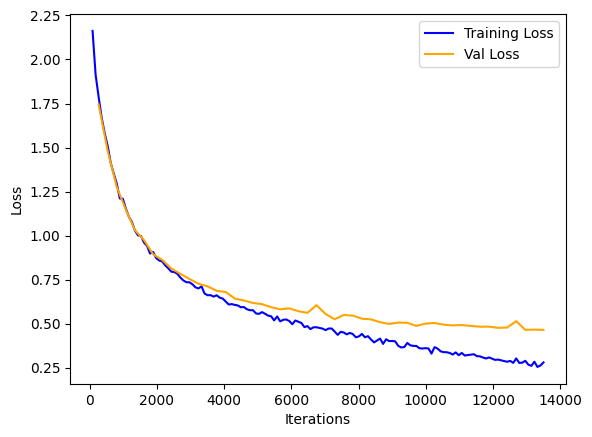

In [32]:
plot_losses(train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx)

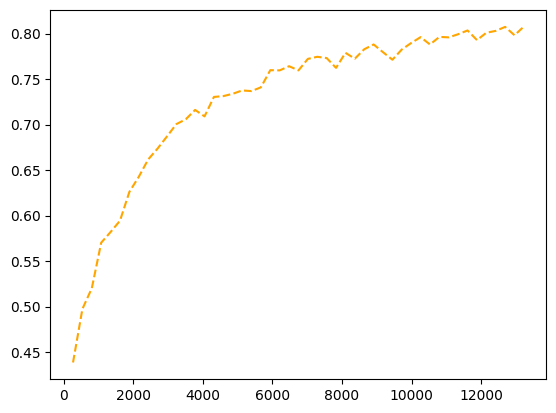

In [ ]:
# plotting validation accuracy
plt.plot(np.array(val_loss_idx), val_acc, color='orange', linestyle='dashed', label='Val Acc')
